In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dropout, Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import skew, bernoulli
from bitstring import BitArray
from deap import base, creator, tools, algorithms

In [2]:
df = pd.read_csv("Airpollution_final_v3.csv")
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.set_index(['date'], drop=True)
print(df.tail())


                     air_pressure  air_temp  cumulative_rain_hours  \
date                                                                 
2017-11-17 17:00:00   10165.19764     -20.0                   10.0   
2017-11-17 18:00:00   10371.00000     -27.0                    6.0   
2017-11-17 19:00:00   10165.19764     -30.0                   10.0   
2017-11-17 20:00:00   10165.19764     -30.0                   10.0   
2017-11-17 21:00:00   10366.00000     -29.0                    6.0   

                     cumulative_snow_hours  dew_point  wind_dir  wind_speed  \
date                                                                          
2017-11-17 17:00:00               85.00000       -220         4       110.0   
2017-11-17 18:00:00                0.75966       -232         4        40.0   
2017-11-17 19:00:00                0.75966       -210         4        50.0   
2017-11-17 20:00:00                0.75966       -200         4        80.0   
2017-11-17 21:00:00                

In [3]:
#Converts dataframe to array
data = df.to_numpy()

#Split into training and test data
data_length = len(data)
train_split = 0.9
train_length = int(train_split * data_length)
test_length = data_length - train_length

x_train = data[0:train_length, :]
x_test = data[train_length:, :]

y_train = data[0:train_length, -1]
y_test = data[train_length:, -1]



(68970, 8)


In [4]:
#Scales the data
x_scaler = MinMaxScaler((0,1))
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler((0,1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

print(x_train_scaled.shape)

(62073, 8)


In [5]:
def LSTMCNNmodel(CNN_size, LSTM_Layer1, LSTM_Layer2, input_shape):
#Builds the model
    lstmcnn = Sequential()
    lstmcnn.add(TimeDistributed(Conv1D(filters=CNN_size, kernel_size=2, activation='relu'), input_shape=input_shape))
    lstmcnn.add(TimeDistributed(MaxPooling1D(pool_size=1)))
    lstmcnn.add(TimeDistributed(Flatten()))
    
    lstmcnn.add(LSTM(LSTM_Layer1, activation='relu', return_sequences=True))
    lstmcnn.add(Dropout(0.2))
    lstmcnn.add(LSTM(LSTM_Layer2, activation='relu', return_sequences=True))
    lstmcnn.add(Dropout(0.2))
    lstmcnn.add(Dense(50, activation='relu'))
    lstmcnn.add(Dense(1, activation='linear'))
    lstmcnn.build()
    return lstmcnn

In [6]:
def split_sequence(sequence, n_steps, window_space=1):
#Windows the data for training
    for j in range(sequence.shape[1]):
        
        data_seq = []
        for i in range(0, len(sequence[:, j]), window_space):
            end_index = i + n_steps
            if end_index > sequence.shape[0]-1:
                break
            x = sequence[i:end_index, j]
            data_seq.append(x) 
            
        data_seq = np.array(data_seq)
        data_seq = np.expand_dims(data_seq, axis=2)
    
        if j == 0:
            data = data_seq
        else:
            data = np.concatenate((data, data_seq), axis=2)    
            
    return (data)

In [7]:
def GetLabels(sequence, n_steps, window_space=1):
# Returns the sequence of labels
    label_seq = []
    for i in range(0, len(sequence), window_space):
        end_index = i + n_steps
        if end_index > len(sequence)-1:
            break
        labels = sequence[end_index]
        label_seq.append(labels)
    
    label_seq = np.array(label_seq)
    label_seq = label_seq.reshape(len(label_seq),1)
    
    return label_seq

In [8]:
#Hyper-Parameters
window_size = 4
window_space = 1
CNN_size = 14
LSTM_Layer1 = 145 
LSTM_Layer2 = 495
learning_rate = 0.0001
epochs = 15
batch_size = 32

#Extract train and test features
train_features = split_sequence(x_train_scaled, window_size, window_space)
test_features = split_sequence(x_test_scaled, window_size, window_space)
train_input, test_input = train_features.reshape((train_features.shape[0], 2, 2, train_features.shape[2])), test_features.reshape((test_features.shape[0], 2, 2, test_features.shape[2]))

input_shape = (None, train_input.shape[2], train_input.shape[3])

#Get train and test labels
train_labels = GetLabels(y_train_scaled, window_size, window_space)
test_labels = GetLabels(y_test_scaled, window_size, window_space)

train_labels, validation_labels = np.expand_dims(train_labels, axis=1), np.expand_dims(test_labels, axis=1)

#Validation Data
validation_data = (test_input, validation_labels)

print(train_input.shape)
print(train_labels.shape)
print(test_input.shape)
print(test_labels.shape)


(62069, 2, 2, 8)
(62069, 1, 1)
(6893, 2, 2, 8)
(6893, 1)


In [9]:
def mse(y_true, y_pred):

    loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_true, predictions=y_pred))
    return loss

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)

model = LSTMCNNmodel(CNN_size, LSTM_Layer1, LSTM_Layer2, input_shape)

model.compile(loss=mse, 
              optimizer=optimiser,
              metrics=['MAE'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 1, 14)       238       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 14)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 145)         92800     
_________________________________________________________________
dropout (Dropout)            (None, None, 145)         0         
_______________________________________

In [10]:
history = model.fit(train_input,
                    train_labels,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=validation_data,
                    shuffle=False)

Train on 62069 samples, validate on 6893 samples
Epoch 1/15
62069/62069 [==============================] - 23s 367us/sample - loss: 0.0037 - mean_absolute_error: 0.0401 - val_loss: 7.8731e-04 - val_mean_absolute_error: 0.0205
Epoch 2/15
62069/62069 [==============================] - 21s 331us/sample - loss: 0.0016 - mean_absolute_error: 0.0256 - val_loss: 5.4174e-04 - val_mean_absolute_error: 0.0164
Epoch 3/15
62069/62069 [==============================] - 20s 330us/sample - loss: 0.0014 - mean_absolute_error: 0.0232 - val_loss: 5.2612e-04 - val_mean_absolute_error: 0.0163
Epoch 4/15
62069/62069 [==============================] - 20s 329us/sample - loss: 0.0013 - mean_absolute_error: 0.0218 - val_loss: 4.8211e-04 - val_mean_absolute_error: 0.0152
Epoch 5/15
62069/62069 [==============================] - 20s 326us/sample - loss: 0.0012 - mean_absolute_error: 0.0210 - val_loss: 4.5258e-04 - val_mean_absolute_error: 0.0144
Epoch 6/15
62069/62069 [==============================] - 20s 327u

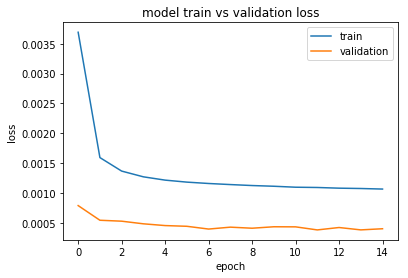

In [11]:
#Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

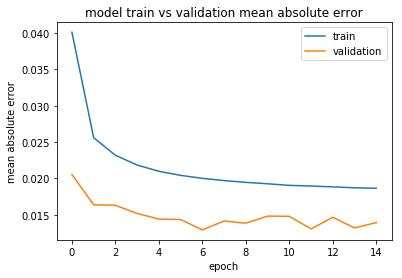

In [12]:
#Plot MAE
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model train vs validation mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

(6893, 2, 1)
(6893, 1)
18.176908833440372


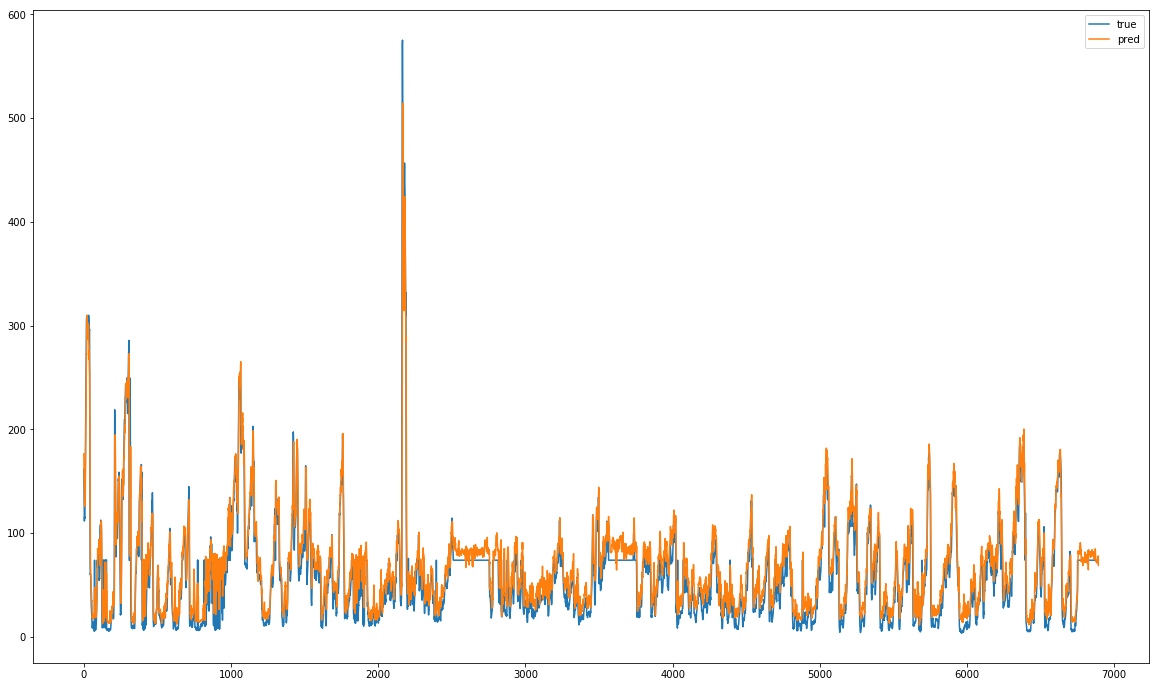

In [13]:
def plot_comparison():

    x = test_input
    # Scale labels back to ground truth
    y_true = y_scaler.inverse_transform(test_labels)
        
    # Use the model to predict the output.
    x_pred = model.predict(x)    
    
    x_pred = np.average(x_pred, axis=1)
    y_pred_rescaled = y_scaler.inverse_transform(x_pred)  


    
    rmse = sqrt(mean_squared_error(y_true, y_pred_rescaled))
    print(rmse)
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(20,12))
    
    # Plot and compare the two signals.
    plt.plot(y_true, label='true')
    plt.plot(y_pred_rescaled, label='pred')
        
    # Plot labels etc.
    plt.legend()
    plt.show()
    
plot_comparison()